In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder

Load the Dataset

In [2]:
data = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')

C:\Users\Huawei\AppData\Local\Temp\ipykernel_13892\1318034804.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')


Remove Unnecessary Columns

In [3]:
data = data.drop(columns=['ehail_fee', 'improvement_surcharge', 'store_and_fwd_flag', 'RatecodeID', 'congestion_surcharge', 'fare_amount', 'extra', 'mta_tax'])

Check number of nulls

In [4]:
data.isnull().sum()

VendorID                 249115
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
PULocationID                  0
DOLocationID                  0
passenger_count          412434
trip_distance                 0
tip_amount                    0
tolls_amount                  0
total_amount                  0
payment_type             412434
trip_type                412434
dtype: int64

Check payment types when tip amount > 0

In [5]:
filtered_data = data[data['tip_amount'] > 0]
filtered_data.groupby('payment_type').size()

payment_type
1.0    298760
3.0         1
dtype: int64

So we consider payment type 1.0 to be a credit card. If a tip was given, assume payment was made by credit card(1.0). (We have just one row with different payment type (3.0), so we change all of the rows with the tip into payment type = 1.0)

In [6]:
data.loc[(data['tip_amount'] > 0), 'payment_type'] = 1.0

Check trip types when passenger count > 4

In [7]:
filtered_data = data[data['passenger_count'] > 4]
filtered_data.groupby('trip_type').size()

trip_type
1.0    22695
2.0      382
dtype: int64

So we consider trip type 1.0 to be dispatch. (We have just 1.66% of rows with different trip type (2.0), so we change all of the rows with the tip into trip type = 1.0)

Check Payment Types

In [8]:
data.groupby('payment_type').size()

payment_type
1.0    461268
2.0    259274
3.0      3891
4.0      1091
5.0         7
dtype: int64

number of payment type = 5.0 is 7, which is so little, we could consider payment type = 5.0 as unknown.

Classify Vans and Set Trip Type

In [9]:
data.loc[data['passenger_count'] > 4, 'trip_type'] = 1.0
data.loc[data['passenger_count'] > 4, 'payment_type'] = 5.0

Remove Rows with Missing VnedorID

In [10]:
data = data.dropna(subset=['VendorID'])

Filter by Year (2021 Only)

In [19]:
data['pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
data['dropoff_datetime'] = pd.to_datetime(data['lpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
data['duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.total_seconds() / 60
data = data[data['pickup_datetime'].dt.year == 2021]
data = data.drop(columns=['lpep_pickup_datetime','lpep_dropoff_datetime'])


In [31]:
data.isnull().mean()


VendorID             0.000000
PULocationID         0.000000
DOLocationID         0.000000
passenger_count      0.199264
trip_distance        0.000000
tip_amount           0.000000
tolls_amount         0.000000
total_amount         0.000000
payment_type         0.163446
trip_type            0.199264
pickup_datetime      0.000000
droppoff_datetime    0.000000
dropoff_datetime     0.000000
duration             0.000000
dtype: float64

In [37]:
def select_features(data, target_column, n_features=4):
    columns=[target_column]

    for column in data.columns:
        if(int(data[column].isnull().sum()) != 0 and column not in columns):
            columns.append(column)

    x_pass = data.drop(columns=columns)
    x_pass = x_pass.select_dtypes(include=[np.number])  # Keep only numeric columns
    y_pass = data[target_column].dropna()  
    x_pass = x_pass.loc[y_pass.index]  # Match indices of x_pass and y_pass

    # Train model
    model = RandomForestClassifier(n_estimators=50, random_state=0)
    model.fit(x_pass, y_pass)

    # Get feature importances
    feature_importances = pd.Series(model.feature_importances_, index=x_pass.columns)

    # Select top features
    selected_features = feature_importances.nlargest(n_features).index.tolist()
    return selected_features

def predict_with_selected_features(data , target_column):
    features = select_features_for_passenger_count(data,target_column)

    missing = data[data[target_column].isnull()]
    train_data = data.dropna(subset=[target_column])

    x_train = train_data[features]
    y_train = train_data[target_column]
    randomforest = RandomForestClassifier(n_estimators=50, random_state=0)
    randomforest.fit(x_train, y_train)

    data.loc[data[target_column].isnull(), target_column] = randomforest.predict(missing[features])
    return data
    

In [38]:
for column in data.columns:
    if(int(data[column].isnull().sum()) != 0):
            predict_with_selected_features(data,column)

data.isnull().sum()

VendorID             0
PULocationID         0
DOLocationID         0
passenger_count      0
trip_distance        0
tip_amount           0
tolls_amount         0
total_amount         0
payment_type         0
trip_type            0
pickup_datetime      0
droppoff_datetime    0
dropoff_datetime     0
duration             0
dtype: int64

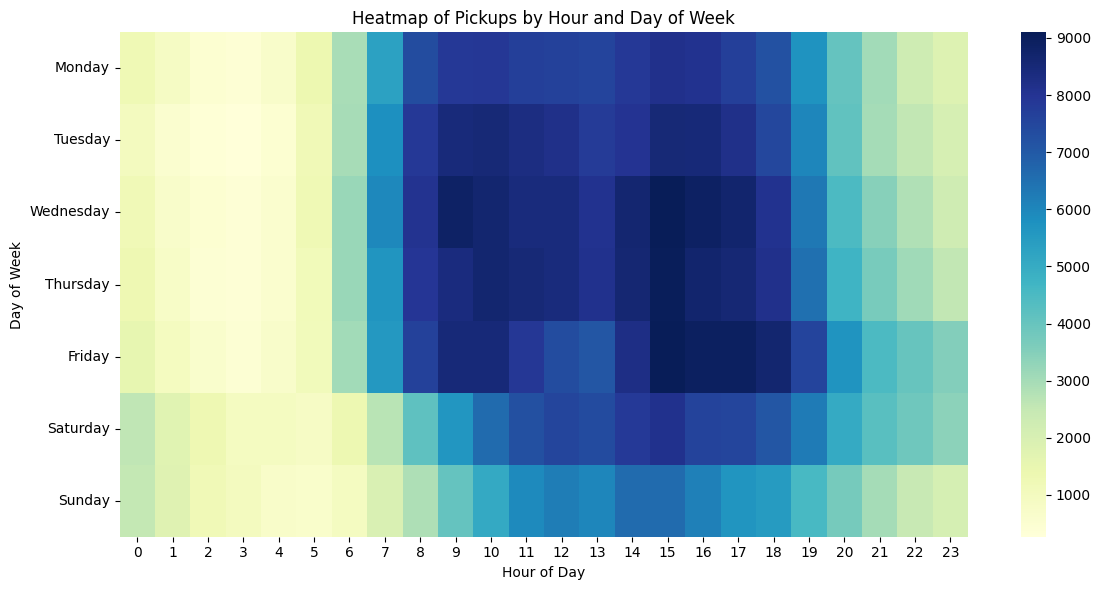

In [40]:
data['day'] = data['pickup_datetime'].dt.day_name()  # Get day of the week
data['hour'] = data['pickup_datetime'].dt.hour  # Get hour

# Create a pivot table with counts
heatmap_data = data.groupby(['day', 'hour']).size().unstack(fill_value=0)

# Reorder days of the week for better visualization
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, cbar=True, fmt='d')
plt.title('Heatmap of Pickups by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()